<a href="https://colab.research.google.com/github/sallyMo14/Prediction-of-Abalone-Sex/blob/main/Prediction_of_Abalone_sex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn import set_config
set_config(transform_output='pandas')

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOT
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray',colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap,colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  fig.tight_layout()
  plt.show()
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
abalone = fetch_ucirepo(id=1)

# data (as pandas dataframes)
X = abalone.data.features
y = abalone.data.targets

# metadata
print(abalone.metadata)

# variable information
print(abalone.variables)


{'uci_id': 1, 'name': 'Abalone', 'repository_url': 'https://archive.ics.uci.edu/dataset/1/abalone', 'data_url': 'https://archive.ics.uci.edu/static/public/1/data.csv', 'abstract': 'Predict the age of abalone from physical measurements', 'area': 'Biology', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular'], 'num_instances': 4177, 'num_features': 8, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['Rings'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C55C7W', 'creators': ['Warwick Nash', 'Tracy Sellers', 'Simon Talbot', 'Andrew Cawthorn', 'Wes Ford'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- 

In [ ]:
df=X.join(y)

In [ ]:
df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [ ]:
X=df.drop(columns=['Sex'])
y=df['Sex']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [ ]:
y_train.value_counts()

,count
Sex,
M,1149
I,992
F,991


*  Is this a balanced data set?
  * Yest it is mostly balanced

In [ ]:
# Categorical Preprocessing Pipeline
# Save list of column names
ohe_cols = X_train.select_dtypes('object').columns
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='constant', fill_value = "Missing")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
# Numerical Preprocessing Pipeline
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)
# Create the Column Transformer
preprocessor = ColumnTransformer([num_tuple, ohe_tuple],
                                 verbose_feature_names_out=False)

OneHotEncoder Columns: Index([], dtype='object')
Numeric Columns: Index(['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight',
       'Viscera_weight', 'Shell_weight', 'Rings'],
      dtype='object')


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
knn_pipe=make_pipeline(preprocessor,knn)
knn_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight',
       'Viscera_weight', 'Shell_weight', 'Rings'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index([], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('kneighborsclassifier', KNeighborsClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           F       0.60      0.69      0.64       991
           I       0.75      0.80      0.78       992
           M       0.69      0.57      0.62      1149

    accuracy                           0.68      3132
   macro avg       0.68      0.69      0.68      3132
weighted avg       0.68      0.68      0.68      3132



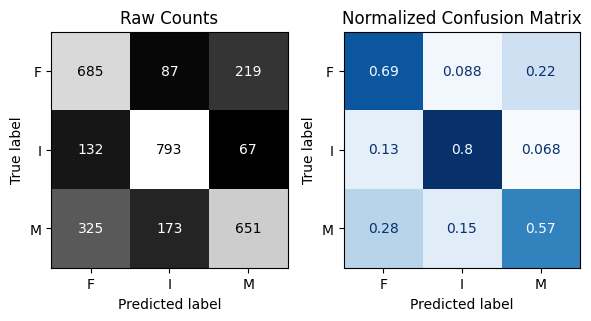


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           F       0.42      0.48      0.45       316
           I       0.70      0.74      0.72       350
           M       0.52      0.42      0.46       379

    accuracy                           0.55      1045
   macro avg       0.55      0.55      0.54      1045
weighted avg       0.55      0.55      0.55      1045



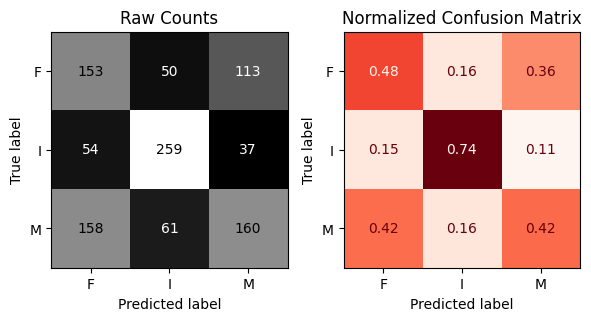

In [ ]:
evaluate_classification(knn_pipe, X_train, y_train, X_test, y_test)

* What is the accuracy of your default model on the training data and the test data?
  *  0.68 for training data
  *  0.55 for testing data
* Which of the 3 classes (M, F, I) does the model predict the best?
  *  The model predicted class I the best
* Provide a rationale/evidence for why you chose that class (Which metric informed your choice?)
  * I used the recall of all classes , and compared between them
  I>F>M

In [ ]:
knn_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight',
          'Viscera_weight', 'Shell_weight', 'Rings'],
         dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='Missing',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                        

In [ ]:
neighbors=list(range(1,50,2))


In [ ]:
param_grid={'kneighborsclassifier__n_neighbors':neighbors,
            'kneighborsclassifier__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}

In [ ]:
gs=GridSearchCV(knn_pipe,param_grid,verbose=1,n_jobs=-1)
gs.fit(X_train,y_train)
gs.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__n_neighbors': 49}

* What were the best params, according to the GridSearch?
  * 'kneighborsclassifier__algorithm': 'auto'
  * 'kneighborsclassifier__n_neighbors': 49

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           F       0.51      0.45      0.48       991
           I       0.67      0.81      0.73       992
           M       0.54      0.50      0.52      1149

    accuracy                           0.58      3132
   macro avg       0.57      0.59      0.58      3132
weighted avg       0.57      0.58      0.57      3132



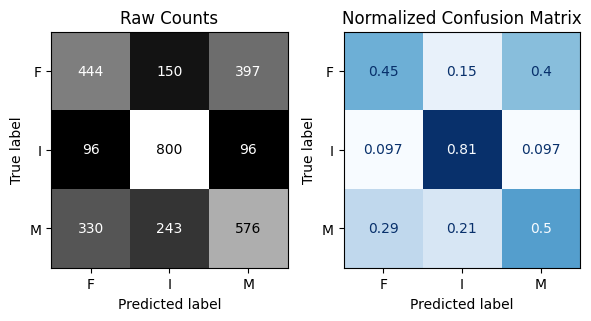


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           F       0.44      0.40      0.42       316
           I       0.70      0.83      0.76       350
           M       0.50      0.46      0.48       379

    accuracy                           0.57      1045
   macro avg       0.55      0.56      0.55      1045
weighted avg       0.55      0.57      0.56      1045



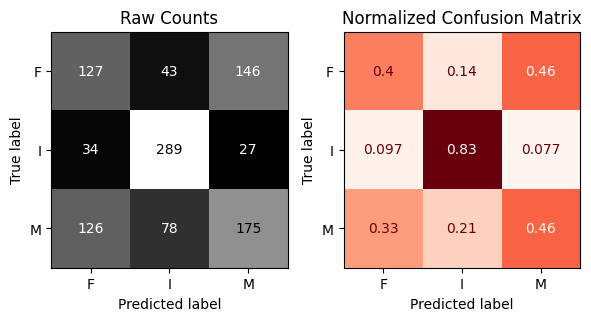

In [ ]:
evaluate_classification(gs.best_estimator_, X_train, y_train, X_test, y_test)

* Were you able to improve the model's performance via GridSearchCV?
  * yes test acurracy incresed (0.55 -> 0.57)
* Did the test accuracy improve?
  * It improved for testing data , but decresed for trsining data
* Did the recall scores improve? (Hint: Use the macro average of recall to answer this question)
  * Incresed for M class (0.42 -> 0.46)
  * Incresed for I class (0.74 -> 0.83)
  * Decresed for F class (0.48 -> 0.4)
  * the macro average recall incrased from slightly improves 0.55 -> 0.56